In [1]:
# Refer from
#  https://pasus.tistory.com/138
#  https://horomary.hatenablog.com/entry/2020/06/26/003806
#  https://keras.io/examples/rl/ddpg_pendulum/
#  https://github.com/dongminlee94/Samsung-DRL-Code/blob/master/5_SAC/sac/model.py
# ! pip 
import gym
import sys
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, concatenate, Lambda
import tensorflow_probability as tfp
tfd = tfp.distributions
from collections import deque
import matplotlib.pyplot as plt

2021-07-30 16:13:13.413551: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
class Actor(tf.keras.Model):
    def __init__(self, state_size, action_size, log_std_min, log_std_max):
        super(Actor, self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.fc1= Dense(64, activation='relu')
        self.fc2= Dense(64, activation='relu')
        # self.fc3 = Dense(16, activation='relu')
        self.mu = Dense(action_size)
        self.log_std= Dense(action_size)

    def call(self, x):
        x       = self.fc1(x)
        x       = self.fc2(x)
        # x       = self.fc3(x)
        mu = self.mu(x)
        log_std = self.log_std(x)
        log_std = tf.clip_by_value(log_std, self.log_std_min, self.log_std_max)
        std = tf.math.exp(log_std)
        return mu, std

class Critic(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.s1 = Dense(16, activation='relu')
        self.s2 = Dense(32, activation='relu')
        self.a1 = Dense(32, activation='relu')
        self.a2 = Dense(32, activation='relu')
        self.fc1= Dense(64, activation='relu')
        self.fc2= Dense(64, activation='relu')
        self.out= Dense(1,  activation='linear')

    def call(self,state,action):
        # state  = state_action[0]
        # action = state_action[1]
        s = self.s1(state)
        s = self.s2(s)
        a = self.a1(action)
        a = self.a2(a)
        c = concatenate([s,a],axis=-1)
        x = self.fc1(c)
        x = self.fc2(x)
        q = self.out(x)
        return q

In [3]:
# https://github.com/dongminlee94/Samsung-DRL-Code/blob/master/5_SAC/sac/utils.py
# https://github.com/RickyMexx/SAC-tf2/blob/master/SAC/SAC_rla.py
# https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/b338c87bebb672e39304e47e0eed55aeb462b243/agents/Base_Agent.py#L278
# 
class TD3Agent:
    def __init__(self, state_size, action_size, action_min, action_max):
        self.state_size = state_size
        self.action_size= action_size
        self.action_min = action_min
        self.action_max = action_max

        # Hyper params for learning
        self.discount_factor = 0.99
        self.critic_learning_rate = 0.002
        self.actor_learning_rate  = 0.001
        self.alpha_learning_rate  = 0.001
        self.tau = 0.005
        self.alpha = 0.200 # temperature

        # Experience Replay
        self.batch_size = 64
        self.train_start = 2000
        self.memory = deque(maxlen=50000)

        self.critic1_optimizer  = tf.keras.optimizers.Adam(learning_rate=self.critic_learning_rate)
        self.critic2_optimizer  = tf.keras.optimizers.Adam(learning_rate=self.critic_learning_rate)
        self.actor_optimizer    = tf.keras.optimizers.Adam(learning_rate=self.actor_learning_rate)
        self.alpha_optimizer    = tf.keras.optimizers.Adam(learning_rate=self.alpha_learning_rate)

        self.critic1        = Critic(self.state_size, self.action_size)
        self.critic2        = Critic(self.state_size, self.action_size)
        self.target_critic1 = Critic(self.state_size, self.action_size)
        self.target_critic2 = Critic(self.state_size, self.action_size)
        self.actor          = Actor(self.state_size, self.action_size, self.action_min, self.action_max)
        self.target_actor   = Actor(self.state_size, self.action_size, self.action_min, self.action_max)
        self.log_alpha      = tf.math.log(0.2)
        self.alpha          = tf.math.exp(self.log_alpha)

        self.actor.build(input_shape=(None, self.state_size))
        self.target_actor.build(input_shape=(None, self.state_size))
        state_in = Input(shape=(self.state_size,),dtype=tf.float32)
        action_in = Input(shape=(self.action_size,),dtype=tf.float32)
        self.actor(state_in)
        self.target_actor(state_in)
        self.critic1(state_in, action_in)
        self.critic2(state_in, action_in)
        self.target_critic1(state_in, action_in)
        self.target_critic2(state_in, action_in)

        self.actor.summary()
        self.critic1.summary()
        # self.critic2.summary()
        
        self.hard_update_target_model()
        self.target_entropy = -tf.convert_to_tensor(np.array(self.action_size,dtype=np.float32),dtype=tf.float32)

        self.train_idx = 0
        self.show_media_info = False

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def hard_update_target_model(self):
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic1.set_weights(self.critic1.get_weights())
        self.target_critic2.set_weights(self.critic2.get_weights())

    def soft_update_target_model(self):
        tau = self.tau
        for (net, target_net) in zip(   self.actor.trainable_variables,
                                        self.target_actor.trainable_variables):
            target_net.assign(tau * net + (1.0 - tau) * target_net)
        for (net, target_net) in zip(   self.critic1.trainable_variables,
                                        self.target_critic1.trainable_variables):
            target_net.assign(tau * net + (1.0 - tau) * target_net)
        for (net, target_net) in zip(   self.critic2.trainable_variables,
                                        self.target_critic2.trainable_variables):
            target_net.assign(tau * net + (1.0 - tau) * target_net)

    def get_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        mu, std = self.actor(state)
        action, _ = self.eval_action(mu,std)
        return action.numpy()[0]

    def eval_action(self, mu, std, epsilon=1e-6):
        action_prob = tfd.Normal(loc=mu, scale=std)
        z = action_prob.sample()
        action = tf.math.tanh(z)
        # action = tf.stop_gradient(action)
        log_prob = action_prob.log_prob(z) - tf.math.log(1.0 - tf.pow(action,2) + epsilon)
        log_prob = tf.reduce_sum(log_prob, axis=-1, keepdims=True)

        return action, log_prob

    # def get_td_error(self,critic, target_critic):
    #     # Update critic
    #     mu, std = self.actor(next_states,training=True)
    #     q = self.target_critic1(next_states,next_actions,training=True)
    #     next_actions, log_pi = self.eval_action(mu, std)
    #     target_q1 = self.target_critic1(next_states,next_actions,training=True)
    #     target_q2 = self.target_critic2(next_states,next_actions,training=True)
    #     target_q_min = tf.minimum(target_q1, target_q2) # Clipping Double Q
    #     td_error = 

    def train_model(self):
        # Train from Experience Replay
        # Training Condition - Memory Size
        if len(self.memory) < self.train_start:
            return 0.0,0.0
        # Sampling from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        
        states      = tf.convert_to_tensor(np.array([sample[0] for sample in mini_batch]))
        actions     = tf.convert_to_tensor(np.array([sample[1] for sample in mini_batch]))
        rewards     = tf.convert_to_tensor(np.array([sample[2] for sample in mini_batch]),dtype=tf.float32)
        rewards     = tf.expand_dims(rewards, axis = 1)
        next_states = tf.convert_to_tensor(np.array([sample[3] for sample in mini_batch]))
        dones       = tf.convert_to_tensor(np.array([sample[4] for sample in mini_batch]),dtype=tf.float32)
        dones       = tf.expand_dims(dones, axis = 1)
        
        if self.show_media_info == False:
            self.show_media_info = True
            print('Start to train, check batch shapes')
            print('**** shape of states', np.shape(states),type(states))
            print('**** shape of actions', np.shape(actions),type(actions))
            print('**** shape of rewards', np.shape(rewards),type(rewards))
            print('**** shape of next_states', np.shape(next_states),type(next_states))
            print('**** shape of dones', np.shape(dones),type(dones))
        
        # Update critic
        mu, std = self.actor(next_states,training=True)
        next_actions, next_log_pi = self.eval_action(mu, std)
        target_q1 = self.target_critic1(next_states,next_actions,training=True)
        target_q2 = self.target_critic2(next_states,next_actions,training=True)
        target_q_min = tf.minimum(target_q1, target_q2) # Clipping Double Q
        target_value = rewards + (1.0 - dones) * self.discount_factor * (target_q_min - self.alpha * next_log_pi)

        with tf.GradientTape() as tape:
            q1 = self.critic1(states, actions, training=True)
            critic1_loss = tf.math.reduce_mean(tf.math.square(target_value - q1))
        critic1_params = self.critic1.trainable_variables
        critic1_grads = tape.gradient(critic1_loss, critic1_params)
        self.critic1_optimizer.apply_gradients(zip(critic1_grads, critic1_params))

        with tf.GradientTape() as tape:
            q2 = self.critic2(states, actions, training=True)
            critic2_loss = tf.math.reduce_mean(tf.math.square(target_value - q2))
        critic2_params = self.critic2.trainable_variables
        critic2_grads = tape.gradient(critic2_loss, critic2_params)
        self.critic2_optimizer.apply_gradients(zip(critic2_grads, critic2_params))

        # Update actor
        with tf.GradientTape() as tape:
            mu, std = self.actor(states,training=True)
            new_actions, new_log_pi = self.eval_action(mu,std)
            new_q1 = self.critic1(states, new_actions,training=True)
            new_q2 = self.critic2(states, new_actions,training=True)
            new_q_min = tf.minimum(new_q1, new_q2)
            actor_loss = tf.reduce_mean(self.alpha * new_log_pi - new_q_min)
        actor_params = self.actor.trainable_variables
        actor_grads = tape.gradient(actor_loss, actor_params)
        self.actor_optimizer.apply_gradients(zip(actor_grads, actor_params))

        # Update alpha
        # with tf.GradientTape() as tape:
        #     alpha_loss = - tf.reduce_mean(self.log_alpha * (new_log_pi + self.target_entropy))
        # alpha_params = self.log_alpha
        # alpha_grads = tape.gradient(alpha_loss, alpha_params)
        # self.alpha_optimizer.apply_gradients(zip(alpha_grads, alpha_params))
        # self.alpha = tf.math.exp(self.log_alpha)

        self.soft_update_target_model()
        critic_loss = 0.5*(critic1_loss.numpy() + critic2_loss.numpy())
        return critic_loss, actor_loss.numpy()
        # return

    def save_model(self):
        self.actor.save_weights("./save_model/pendulum_td3_TF_actor", save_format="tf")
        self.critic1.save_weights("./save_model/pendulum_td3_TF_critic1", save_format="tf")
        self.critic2.save_weights("./save_model/pendulum_td3_TF_critic2", save_format="tf")
        return


2021-07-30 16:13:14.730335: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-30 16:13:14.731583: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-30 16:13:14.780929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 68 deviceMemorySize: 9.75GiB deviceMemoryBandwidth: 707.88GiB/s
2021-07-30 16:13:14.781008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-30 16:13:14.785839: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-30 16:13:14.785950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-0

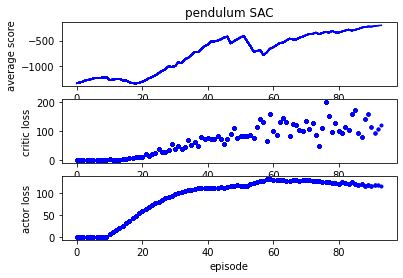

In [4]:
%matplotlib tk

ENV_NAME = 'Pendulum-v0'
EPISODES = 500
END_SCORE = -200

if __name__ == "__main__":
    env = gym.make(ENV_NAME)
    state_size      = env.observation_space.shape[0]
    action_size     = env.action_space.shape[0]
    log_std_min     = -20.0
    log_std_max     = 5.0

    agent = TD3Agent(state_size, action_size, log_std_min, log_std_max)
    print('Env Name : ',ENV_NAME)
    print('States {0}, Actions {1}'.format(state_size, action_size))
    print('Action scale exp({0:.2f} ~ {1:.2f})'.format(log_std_min, log_std_max))
    scores_avg, scores_raw, episodes, losses = [], [], [], []
    critic_mean, actor_mean = [], []
    score_avg = 0
    critics = 0
    actors = 0

    end = False
    show_media_info = True
    
    fig = plt.figure(1)
    fig.clf()
    
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        critic_losses = []
        actor_losses = []
        while not done:
            # if e%100 == 0:
            #     env.render()
            # Interact with env.
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            critic_loss, actor_loss = agent.train_model()
            state = next_state
            # 
            score += reward
            critic_losses.append(critic_loss)
            actor_losses.append(actor_loss)
            if show_media_info:
                print("-------------- Variable shapes --------------")
                print("State Shape : ", np.shape(state))
                print("Action Shape : ", np.shape(action))
                print("Reward Shape : ", np.shape(reward))
                print("done Shape : ", np.shape(done))
                print("---------------------------------------------")
                show_media_info = False
            if done:
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {0:3d} | score avg: {1:3.2f} | mem size {2:6d} |"
                    .format(e, score_avg, len(agent.memory)))

                episodes.append(e)
                scores_avg.append(score_avg)
                scores_raw.append(score)

                critic_mean.append(np.mean(critic_losses))
                actor_mean.append(np.mean(actor_losses))
                plt.subplot(311)
                plt.plot(episodes, scores_avg, 'b')
                plt.xlabel('episode'); plt.ylabel('average score'); plt.grid()
                plt.title('pendulum SAC')
                plt.subplot(312)
                plt.plot(episodes, critic_mean, 'b.')
                plt.xlabel('episode'); plt.ylabel('critic loss'); plt.grid()
                plt.subplot(313)
                plt.plot(episodes, actor_mean, 'b.')
                plt.xlabel('episode'); plt.ylabel('actor loss'); plt.grid()
                plt.savefig("./result/pendulum_sac_TF.png")


                # 이동 평균이 0 이상일 때 종료
                if score_avg > END_SCORE:
                    agent.save_model()
                    end = True
                    break
                
            # break
        if end == True:
            env.close()
            np.save('./save_model/data/pendulum_sac_TF_epi',  episodes)
            np.save('./save_model/data/pendulum_sac_TF_score',scores)
            print("End")
            break

In [5]:
env.close()